# Normalize HuBMAP and KPMP datasets for comparison

## Install pre-requisite libraries

In [36]:
!pip install anndata pandas seaborn matplotlib requests

## Part 1: extract obs variables to csv

### Imports / functions

In [37]:
import anndata

In [38]:
def h5ad_obs_to_csv(input_h5ad):
    output_csv = input_h5ad.replace('.h5ad', '.obs.csv')
    x = anndata.read_h5ad(input_h5ad, backed='r')
    x.obs.to_csv(output_csv)

### Datasets to load

In [39]:
datasets = {
  'KPMP SC RNAseq': 'kpmp-sc-rnaseq.h5ad',
  'KPMP SN RNAseq': 'kpmp-sn-rnaseq.h5ad',
  'HuBMAP Left Kidney': 'hubmap-LK-processed.h5ad',
  'HuBMAP Right Kidney': 'hubmap-RK-processed.h5ad'
}

### Write out dataset obs variables to separate csv files

In [40]:
for h5ad in datasets.values():
    h5ad_obs_to_csv(h5ad)

In [41]:
!head -3 *.csv

==> hubmap-LK-processed.obs.csv <==
cell_id,uuid,hubmap_id,age,sex,height,weight,bmi,cause_of_death,race,barcode,dataset,azimuth_label,azimuth_id,predicted_CLID,predicted_label,cl_match_type,prediction_score,n_genes,n_counts,leiden
853ab5348f619043ab2f997ac8ae14f0-AAACCCACAAGGTCTT,853ab5348f619043ab2f997ac8ae14f0,HBM344.QRJX.878,25.0,Female,160.0,86.0,33.5,Anoxia,White,AAACCCACAAGGTCTT,853ab5348f619043ab2f997ac8ae14f0,Inner Medullary Collecting Duct,AZ:0000043,CL:1000718,kidney inner medulla collecting duct principal cell,skos:exactMatch,0.496638591002264,564,708.0403,6
853ab5348f619043ab2f997ac8ae14f0-AAACCCACAGTAGTGG,853ab5348f619043ab2f997ac8ae14f0,HBM344.QRJX.878,25.0,Female,160.0,86.0,33.5,Anoxia,White,AAACCCACAGTAGTGG,853ab5348f619043ab2f997ac8ae14f0,Inner Medullary Collecting Duct,AZ:0000043,CL:1000718,kidney inner medulla collecting duct principal cell,skos:exactMatch,0.518361055840066,425,459.7237,6

==> hubmap-RK-processed.obs.csv <==
cell_id,uuid,hubmap_id,age,sex,height,wei

## Part 2: normalize and combine obs datasets

### Imports / functions

In [42]:
import requests
import json

In [43]:
def normalize_category(str):
    str = str.strip()
    if str == "" or str == "unknown":
        return "Unknown"
    else:
        return str

def normalized_age(age):
    cases = {
        "first": 0,
        "second": 10,
        "third": 20,
        "fourth": 30,
        "fifth": 40,
        "sixth": 50,
        "seventh": 60,
        "eighth": 70,
        "nineth": 80,
        "tenth": 90
    }
    age = str(cases.get(age.split(" ")[0], age))
    if age != "" and age[0].isdigit():
        return f"{age[0]}0-{age[0]}9"
    else:
        return normalize_category(age)

def normalize_race(race):
    if race == "African American":
        return "Black or African American"
    else:
        return normalize_category(race)

_donor_cache = {}
def add_hubmap_donor_info(row):
    if row["sex"] == "Unknown" or row["age"] == "Unknown" or row["race"] == "Unknown":
        uuid = row["dataset_id"]
        if uuid in _donor_cache:
            donor = _donor_cache[uuid]
        else:
            url = f"https://entity.api.hubmapconsortium.org/datasets/{uuid}/donors"
            donor_data = json.loads(requests.get(url).content)[0]
            metadata = donor_data["metadata"]["living_donor_data"]
            donor = {}
            for md in metadata:
                key = md["grouping_concept_preferred_term"].lower()
                if key == "sex" or key == "race":
                    donor[key] = md["preferred_term"]
                elif key == "age":
                    donor[key] = md["data_value"]
                    if md["units"] == "months":
                        donor[key] = str(float(donor[key]) / 12)
                    donor[key] = normalized_age(donor[key])
            _donor_cache[uuid] = donor

        for (key, value) in donor.items():
            row[key] = value

def normalize_hubmap_row(row, collection):
    normalized_row = {
        "consortium": "HuBMAP",
        "collection": collection,
        "dataset_id": row["uuid"],
        "cell_id": row["cell_id"],
        "as_id": "UBERON:0002113",
        "cl_id": row["predicted_CLID"],
        "cl_label": row["predicted_label"],
        "gene_count": int(row["n_genes"]),
        "age": normalized_age(row["age"]),
        "sex": normalize_category(row["sex"].title()),
        "race": normalize_race(row["race"]),
        "disease": "normal"
    }
    add_hubmap_donor_info(normalized_row)
    return normalized_row

def normalize_kpmp_row(row, collection):
    normalized_row = {
        "consortium": "KPMP",
        "collection": collection,
        "dataset_id": row.get("LibraryID", row.get("library_id", "Unknown")),
        "cell_id": row[""],
        "as_id": row["tissue_ontology_term_id"],
        "cl_id": row["cell_type_ontology_term_id"],
        "cl_label": row["cell_type"],
        "gene_count": int(float(row["nCount_RNA"])),
        "age": normalized_age(row["Age_binned"]),
        "sex": normalize_category(row["sex"].title()),
        "race": normalize_race(row["self_reported_ethnicity"]),
        "disease": normalize_category(row["disease"])
    }
    return normalized_row

fields = ["consortium", "collection", "dataset_id", "cell_id", "as_id", "cl_id", "cl_label", "gene_count", "age", "sex", "race", "disease"]

### Read in obs data and write out a normalized csv

In [44]:
import csv
import gzip
with gzip.open("all-normalized-obs.csv.gz", 'wt', compresslevel=9, newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fields)
    writer.writeheader()
    for (collection, h5ad) in datasets.items():
        obs_csv = h5ad.replace(".h5ad", ".obs.csv")
        with open(obs_csv, newline='') as obs_csvfile:
            reader = csv.DictReader(obs_csvfile)
            for row in reader:
                if h5ad.startswith("hubmap-"):
                    normalized_row = normalize_hubmap_row(row, collection)
                else:
                    normalized_row = normalize_kpmp_row(row, collection)
                writer.writerow(normalized_row)


In [45]:
!zcat all-normalized-obs.csv.gz | head -3

consortium,collection,dataset_id,cell_id,as_id,cl_id,cl_label,gene_count,age,sex,race,disease
KPMP,KPMP SC RNAseq,5655_EO-2,S2008000605HRT_AAACCCAGTGCACATT-1,UBERON:0002113,CL:1001431,kidney collecting duct principal cell,10505,50-59,Male,European,normal
KPMP,KPMP SC RNAseq,5655_EO-2,S2008000605HRT_AAACCCAGTGCCTACG-1,UBERON:0002113,CL:1001431,kidney collecting duct principal cell,9698,50-59,Male,European,normal

gzip: stdout: Broken pipe


## Part 3: show basic results

### Imports / functions

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

### Display unique values in normalized data

In [47]:
df = pd.read_csv("all-normalized-obs.csv.gz")

# Create a dictionary to store unique values for each column
unique_values = {column: df[column].unique() for column in df.columns}

# Print unique values for each column
for column, values in unique_values.items():
    if len(values) < 100:
        print(f"\"{column}\" values ({len(values)}): {', '.join(values)}")
    else:
        print(f"\"{column}\" values ({len(values)}): {', '.join(map(str, values))[:200]}...")

"consortium" values (2): KPMP, HuBMAP
"collection" values (4): KPMP SC RNAseq, KPMP SN RNAseq, HuBMAP Left Kidney, HuBMAP Right Kidney
"dataset_id" values (379): 5655_EO-2, 5655_EO-3, 5655_EO-4, 5655_EO-5, 6034-EO-2, 6034-EO-3, 6034-EO-4, 6034-EO-5, 1117-EO-1, 1119-EO-1, 613-EO-2, 622-EO-2, 1119-EO-2, 1120-EO-1, 593-EO-1, 763-EO-4, 1120-EO-2, 573-EO-2, 2318-EO...
"cell_id" values (2304020): S2008000605HRT_AAACCCAGTGCACATT-1, S2008000605HRT_AAACCCAGTGCCTACG-1, S2008000605HRT_AAAGAACGTAGAGACC-1, S2008000605HRT_AAAGAACGTCGGAACA-1, S2008000605HRT_AAAGAACGTTAACAGA-1, S2008000605HRT_AAAGGATAGT...
"as_id" values (4): UBERON:0002113, UBERON:0001225, UBERON:0001228, UBERON:0000362
"cl_id" values (63): CL:1001431, CL:1000500, CL:1001111, CL:0000115, CL:0002306, CL:1001106, CL:1001107, CL:1001432, CL:0000910, CL:0000875, CL:0000990, CL:0000084, CL:1000695, CL:0000814, CL:0000786, CL:0000113, CL:0000576, CL:0000236, CL:0000623, CL:0001058, CL:0000097, CL:1000849, CL:0000653, CL:1000452, CL:1000768

### Visualize distributions of metadata by cell

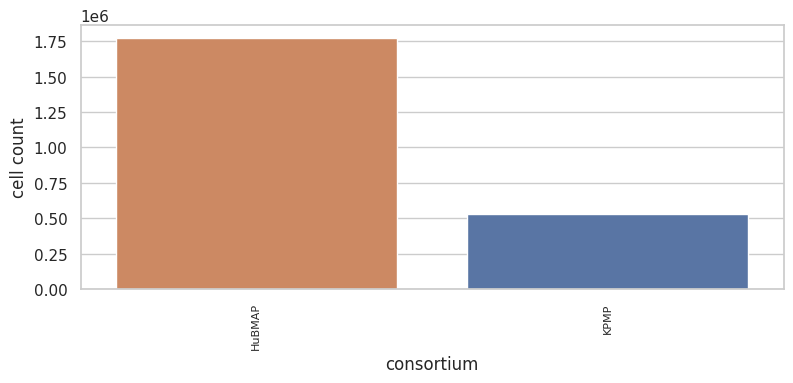

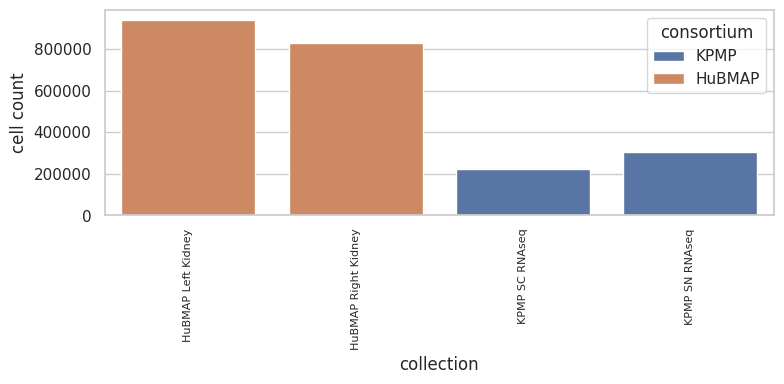

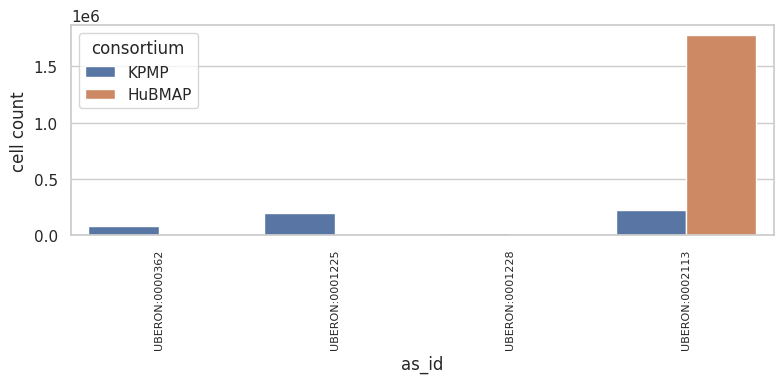

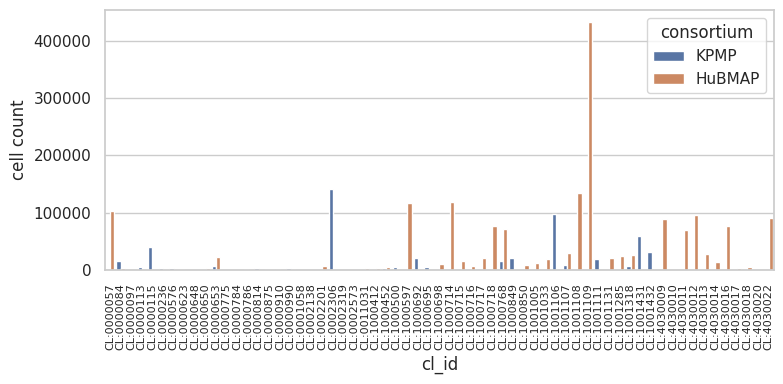

/tmp/ipykernel_23447/1976136301.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


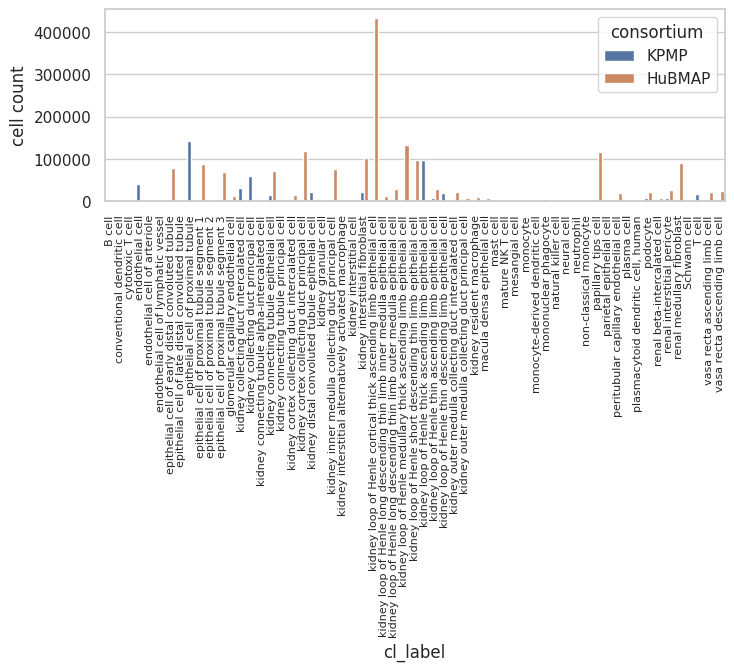

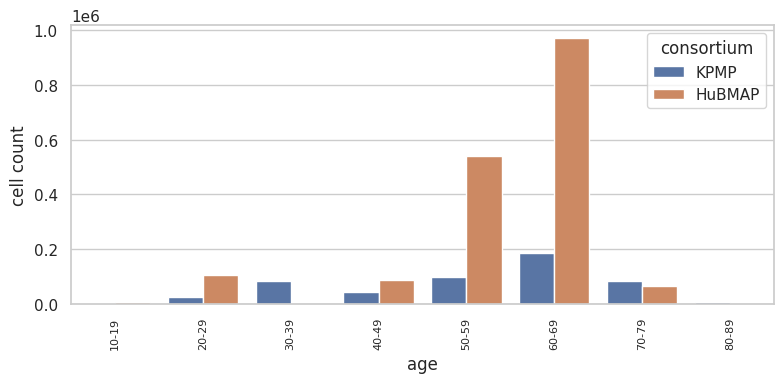

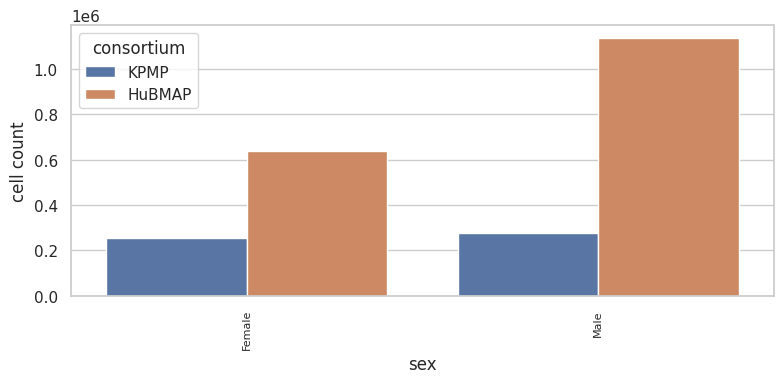

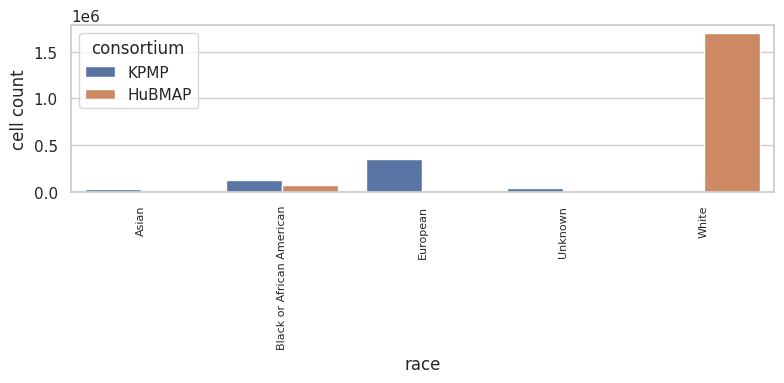

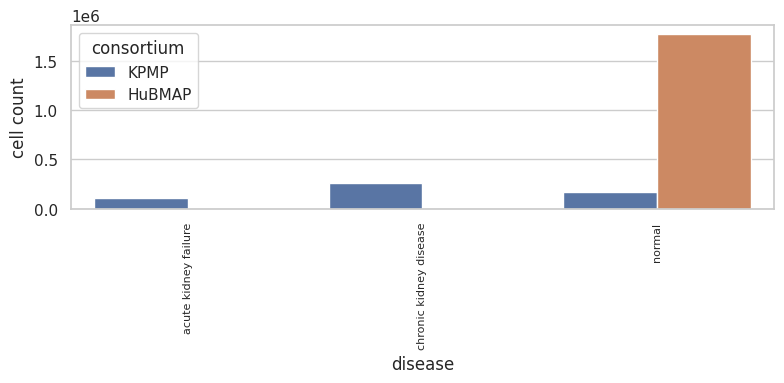

In [52]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

def plot_distribution(x, column):
    plt.figure(figsize=(8, 4))
    plt.xticks(rotation=90, fontsize=8)
    sorted_values = sorted(unique_values[column], key=lambda v: v.lower())
    sns.countplot(x=column, data=x, order=sorted_values, hue='consortium')
    plt.gcf().subplots_adjust(bottom=0.4)
    plt.xlabel(column)
    plt.ylabel('cell count')
    plt.tight_layout()
    plt.show()

# Plot the distribution of each column
for column in df.columns:
    if len(unique_values[column]) < 100:
        plot_distribution(df, column)
